# CNN 발전 시키기

>### [예제 9] Digit Sign - DensenNet활용

>### Load modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.model_selection import train_test_split

print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

NumPy Version :1.18.5
TensorFlow Version :2.3.0
Matplotlib Version :3.2.2


> ### Load Digit Sign Data

In [2]:
colab=True
try:
  from google.colab import drive
except:
  colab =False
if colab : 
    drive.mount('/content/drive')
    print('g-drive mounted.')
else : print('local drive.')

Mounted at /content/drive
g-drive mounted.


In [3]:
# file path: 다른 경로에 실습파일을 복사했다면, 아래 경로를 수정하세요

if colab : 
  !unzip -q -o /content/drive/My\ Drive/files/Sign-Language-Digits-Dataset-master.zip
  files_path = '/content/Sign-Language-Digits-Dataset-master/Dataset/'
else : 
  files_path = 'c:/files/Sign-Language-Digits-Dataset-master/datasets/'

In [4]:
IMG_SIZE = 64
first = True
for ind in range(0, 10, 1) :
  path = files_path + str(ind) + '/*.*'
  print(path)
  files = glob.glob(path)
  tmpx = np.array([(cv2.resize(cv2.cvtColor(cv2.imread(x, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB), (IMG_SIZE,IMG_SIZE))) for x in files])
  tmpy = np.array([ind] * len(files))
  xtrain, xtest, ytrain, ytest = train_test_split(tmpx, tmpy, test_size=0.2, random_state=123)
  if first == True:
    train_data = xtrain.copy()
    train_labels = ytrain.copy()
    test_data = xtest.copy()
    test_labels = ytest.copy()
    first = False
  else :
    train_data = np.concatenate((train_data, xtrain))
    train_labels = np.concatenate((train_labels, ytrain))
    test_data = np.concatenate((test_data, xtest))
    test_labels = np.concatenate((test_labels, ytest))

/content/Sign-Language-Digits-Dataset-master/Dataset/0/*.*
/content/Sign-Language-Digits-Dataset-master/Dataset/1/*.*
/content/Sign-Language-Digits-Dataset-master/Dataset/2/*.*
/content/Sign-Language-Digits-Dataset-master/Dataset/3/*.*
/content/Sign-Language-Digits-Dataset-master/Dataset/4/*.*
/content/Sign-Language-Digits-Dataset-master/Dataset/5/*.*
/content/Sign-Language-Digits-Dataset-master/Dataset/6/*.*
/content/Sign-Language-Digits-Dataset-master/Dataset/7/*.*
/content/Sign-Language-Digits-Dataset-master/Dataset/8/*.*
/content/Sign-Language-Digits-Dataset-master/Dataset/9/*.*


In [5]:
train_data = train_data.astype(np.double)
train_data = train_data / 255.0

test_data = test_data.astype(np.double)
test_data = test_data / 255.0

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(1645, 64, 64, 3)
(1645,)
(417, 64, 64, 3)
(417,)


>### Create Model


In [6]:
model = tf.keras.models.Sequential()
#model.add(tf.keras.applications.vgg16.VGG16(
model.add(tf.keras.applications.densenet.DenseNet121(
    # 경로가 막혀 자동 다운로드가 안 될 경우 아래 링크를 클릭하여 파일 다운로드 받고, 
    # 그 경로를 아래 weights에 설정
#     weights="c:/files/densenet121.h5", 
    weights="imagenet", 
    include_top=False,    # dense layer 이 후는 제외
    input_tensor=tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    ))
# Dense layers
model.add(tf.keras.layers.Flatten(name='flatten'))
model.add(tf.keras.layers.Dense(1024, activation='relu',name='dense_1024'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation='softmax', name='dense_10'))

model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 2, 2, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense_1024 (Dense)           (None, 1024)              4195328   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                10250     
Total params: 11,247,178
Trainable params: 11,161,482
Non-trainable params: 85,696
_________________________________________________________________


>### Compile Model

In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

> ### 학습 전 상황

In [8]:
def Make_Result_Plot(suptitle:str, data:np.ndarray, label:np.ndarray, y_max:np.ndarray):
    fig_result, ax_result = plt.subplots(2,5,figsize=(18, 7))
    fig_result.suptitle(suptitle)
    for idx in range(10):
        ax_result[idx//5][idx%5].imshow(data[idx*40+40].reshape((IMG_SIZE,IMG_SIZE, 3)),cmap="binary")
        ax_result[idx//5][idx%5].set_title("test_data[{}] (label : {} / y : {})".format(idx*40+40, label[idx*40+40], y_max[idx*40+40]))

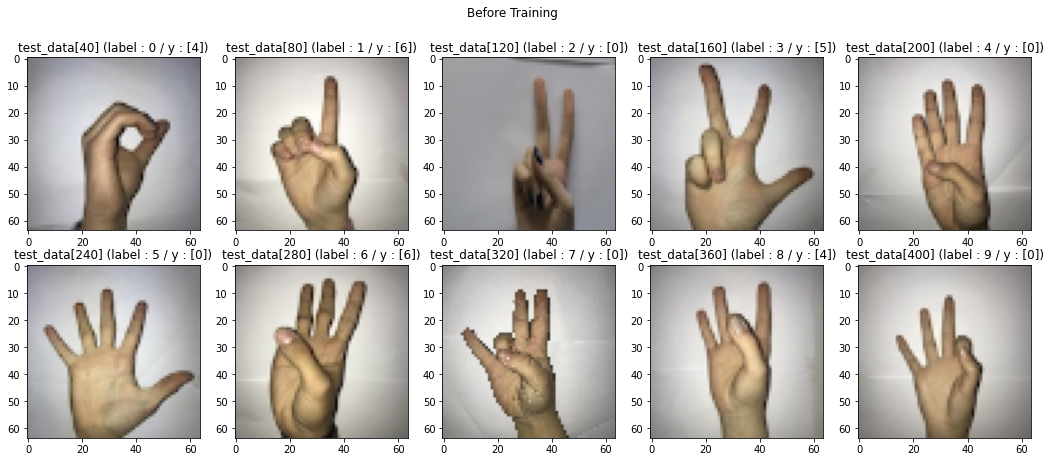

In [9]:
y_out = model.predict(test_data)
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("Before Training", test_data, test_labels, y_max)

> ### 학습 (Training)

In [10]:
%%time
history = model.fit(train_data, train_labels, 
                        shuffle=True,
                        batch_size=128, 
                        epochs=20,
                        validation_data=(test_data, test_labels))

Epoch 1/20
13/13 [==============================] - 5s 380ms/step - loss: 0.9504 - accuracy: 0.7094 - val_loss: 46.9514 - val_accuracy: 0.1823
Epoch 2/20
13/13 [==============================] - 2s 120ms/step - loss: 0.1291 - accuracy: 0.9593 - val_loss: 84.5524 - val_accuracy: 0.1199
Epoch 3/20
13/13 [==============================] - 2s 120ms/step - loss: 0.0331 - accuracy: 0.9872 - val_loss: 53.2851 - val_accuracy: 0.1894
Epoch 4/20
13/13 [==============================] - 2s 120ms/step - loss: 0.0135 - accuracy: 0.9951 - val_loss: 22.2482 - val_accuracy: 0.2998
Epoch 5/20
13/13 [==============================] - 2s 121ms/step - loss: 0.0258 - accuracy: 0.9915 - val_loss: 6.4376 - val_accuracy: 0.5683
Epoch 6/20
13/13 [==============================] - 2s 121ms/step - loss: 0.0423 - accuracy: 0.9891 - val_loss: 3.6985 - val_accuracy: 0.7026
Epoch 7/20
13/13 [==============================] - 2s 120ms/step - loss: 0.0245 - accuracy: 0.9927 - val_loss: 3.5727 - val_accuracy: 0.7386
Ep

> ### Ploting : Cost/Training Count

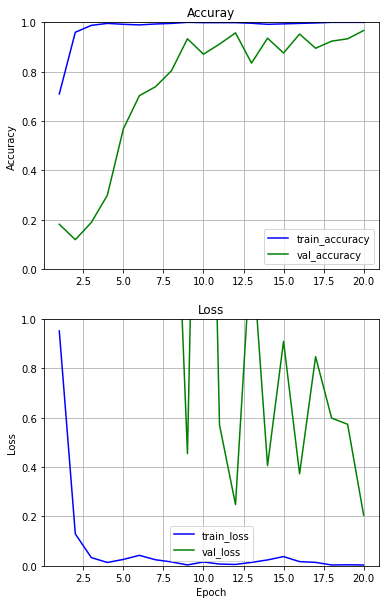

In [11]:
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(6, 10))
plt.subplot(2, 1, 1)
plt.title('Accuray')
plt.plot(epochs, history.history['accuracy'], 'b', label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'g', label='val_accuracy')
plt.ylim([0,1])
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
plt.ylim([0,1])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

> ### Training 이후

In [12]:
print(np.max(history.history['val_accuracy']))

0.9664268493652344


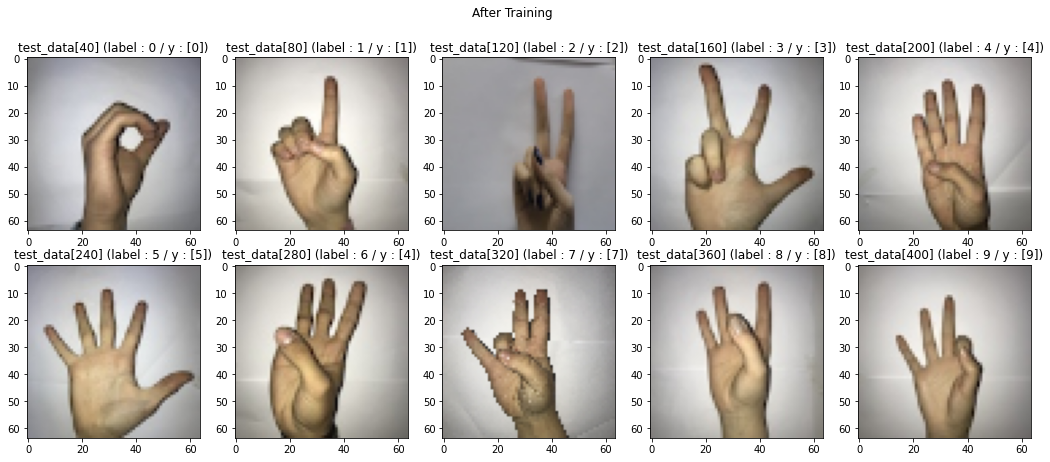

In [13]:
y_out = model.predict(test_data)
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("After Training", test_data, test_labels, y_max)